# Reverse kinematics problem

## Opis problemu

Problem polega na wielokrotnym rozwiązaniu problemu reverse kinematics (opisanego poniżej) dla kolejnych czasów. Rozwiązaniem jest lista kolejnych rozwiązań problemu dla kolejnych czasów.

Instancja problemu (ReverseKinProblem) składa się z:
- ramienia robota (ReverseKinProblem.robot_arm : RobotArm) zdefiniowanego przez długości segmentów (RobotArm.lengths) oraz maksymalne i minimalne kąty zgięć (RobotArm.anglemax, RobotArm.anglemin). 
- punktu docelowego (ReverseKinProblem.targetX, ReverseKinProblem.targetY)
- przeszkód (ReverseKinProblem.obstacles: List[Obstacle]) - każda przeszkoda jest zdefiniowana przez jej stan początkowy (Obstacle.starting_obj) oraz jej funkcję ruchu zależną od czasu (Obstacle.movement)

Rozwiązujemy problem optymalizacji gdzie funkcją celu jest kwadrat odległości między końcem ramienia a punktem docelowym. Chcemy minimalizować tę odległość.

Rozwiązaniem problemu jest lista kątów zgięć ramienia.
Przestrzeń poszukiwań to przestrzeń rozwiązań, rozważamy tylko ramiona zgodne ze specyfikacją problemu, czyli o kątach w odpowiednich zakresach. Osobniki niezgodne poprawiamy zmieniając niepoprawne kąty do bliższego z kątów na brzegu przedziału za pomocą funkcji RobotArm.correct_to_edges.
Rozwiązania kolidujące z przeszkodami są częściowo akceptowane - staramy się ich unikać, ale w przypadku nie znalezienia wystarczająco dobrego rozwiązania akceptujemy je.

## Algorytm

Do rozwiązania problemu użyłam lekko zmodyfikowanej strategii ewolucyjnej ES($\mu + \lambda$).  
Dla kolejnych czasów rozwiązujemy problem za pomocą strategii, ale zamiast inicjalizować nową populację używamy wyewoluowanej populacji dla poprzednio rozważanego czasu - jako że punkt docelowy ani ramie robota nie zmienają się w czasie spodziewamy się, że rozwiązania będą podobne. Problem stanowią rozwiązania, które zaczynają kolidować z przeszkodami - dla tych osobników zwiększamy sigmy, aby zwiększyć obszar poszukiwań i znaleźć rozwiązania nie kolidujące z przeszkodami.   
Aby promować osobniki nie kolidujące z przeszkodami zmieniłam funkcję celu tak, że dla każdemu kolidującemu osobnikowi dodajemy do jego kwadratu odległości do celu pewną dodatnią liczbę (Algoritm.penalty). Oznacza to, że jeżeli istnieje niekolidujący osobnik w odległości od celu mniejszej niż Algoritm.penalty to wybierzemy go nawet jeśli istnieje kolidujący osobnik bliżej.  

Dla danego czasu wykonujemy tylko kilka iteracji algorytmu (Algoritm.iteration_per_time), wykonujemy ich mniej jeśli znaleźliśmy odpowiednio dobre rozwiązanie (szczegóły w Algoritm.termination_condition). 

## Wnioski i podsumowanie
Algorytm radzi sobie dobrze w większości przypadków. Ma problemy gdy pojawia się duża liczba przeszkód - myślę że gdyby miał więcej iteracji dla danego czasu to radziłby sobie też z tymi przypadkami. Algorytm źle też sobie radzi gdy przeszkody go zaskakują, więc gdyby zmniejszyć Algoritm.timestep w wyniku czego przeszkody poruszałyby się płynniej to osobniki kolidujące pozostałe z poprzedniego czasu znajdowałyby w swoim otoczeniu więcej poprawnych osobników.



## Perspektywy rozwoju

Pomysły na modyfikacje problemu: 
- Projekt możnaby rozwinąć wprowadzając poruszający się cel - wydaje mi się dostosowanie obecnego algorytmu do tego problemu byłoby możliwe.
- Można również wprowadzić inaczej ruszające się przeszkody, albo przeszkody zmieniające kształt - wystarczy dodać odpowiednią funkcję do SimpleObstacle.movement. Do napisania takiej funkcji należałoby wykorzystać możliwości biblioteki shapely.

Pomysły na modyfikację algorytmu:
- zwiększenie liczby iteracji algorytmu dla czasu 0 - do rozwiązywania trudniejszych problemów typu labirynt
- zamiast zwiększać funkcję celu dla kolidujących osobników możnaby zmodyfikować algorytm tak, aby zawsze przeżywał tylko pewien procent kolidujących osobników. W razie za małej liczby niekolidujących osobników można uzupełnić populację losowymi osobnikami lub nowo utworzonymi osobnikami potomnymi z niekolidujących rodziców
- algorytm sprawdza tylko czy dany osobnik koliduje z przeszkodami czy nie - można by liczyć długość ramienia robota kolidującego z przeszkodami i w ten sposób wybierać osobniki mniej kolidujące z przeszkodami. Wydaje mi się jednak, że takie obliczenie jest bardziej skomplikowane niż tylko sprawdzenie kolizji, więc wymagało by więcej czasu
- zachowywać stan populacji po znalezieniu wystarczająco dobrego rozwiązania np. w odległości 0.1 i użycie go dla kolejnego czasu - możemy w ten sposób znajdować lepsze rozwiązanie, a jednocześnie dla następnego czasu mamy przawdopodobnie nieco bardziej różnorodną populację oraz większe sigmy osobników niż dla bardziej wyewoluowanej populacji


# Testy

In [1]:
from test_examples import *
from numpy.random import seed
seed(62548)

## Test 1 - statyczna przeszkoda

static_animation.mp4

Sanity check - algorytm bez problemu radzi sobie z pojedyńczą przeszkodą

In [2]:
test1 = single_static_obstacle()
test1.test()

Iteration 0000 : best score = 0.18985446, mean score = 7.12787325.
Iteration 0002 : best score = 0.00595013, mean score = 2.38470918.
Iteration 0004 : best score = 0.00548121, mean score = 1.22953025.
Iteration 0006 : best score = 0.00269096, mean score = 1.16102382.
Iteration 0008 : best score = 0.00002920, mean score = 1.09027775.
Iteration 0010 : best score = 0.00002920, mean score = 0.56078999.
Iteration 0012 : best score = 0.00002920, mean score = 0.14795023.
Iteration 0014 : best score = 0.00002920, mean score = 0.03317925.


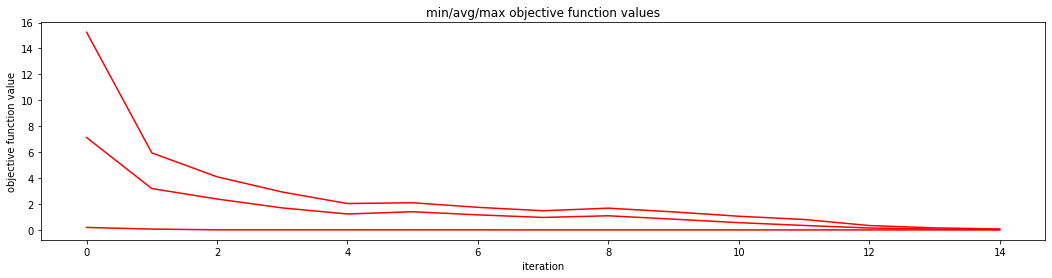

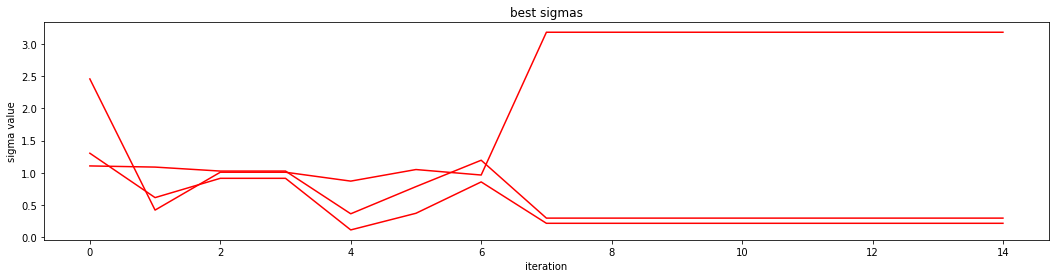

In [3]:
test1.print_plots()

Saving animation...Done


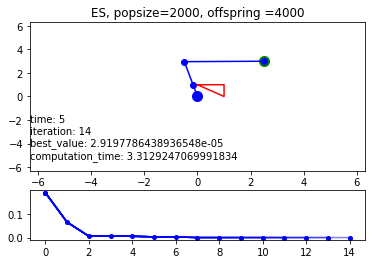

In [4]:
test1.save_animation("static_obstacle")

## Test 2 - dwie ruchome przeszkody
double_moving_obstacles.mp4


Algorytm radzi sobie z dwoma prostymi przeszkodami.

In [5]:
test2 = double_moving_obstacles()
test2.test()

Iteration 0000 : best score = 0.00446372, mean score = 6.63074207.
Iteration 0005 : best score = 0.01364094, mean score = 1.29916069.
Iteration 0010 : best score = 0.00965853, mean score = 0.89151848.
Iteration 0015 : best score = 0.00026372, mean score = 0.87279293.
Iteration 0020 : best score = 0.00014700, mean score = 0.06838663.
Iteration 0025 : best score = 0.00001712, mean score = 0.00576561.
Iteration 0030 : best score = 0.00000042, mean score = 0.00041422.
Iteration 0035 : best score = 0.00000003, mean score = 0.00002319.
Iteration 0040 : best score = 0.00012174, mean score = 0.61465303.
Iteration 0045 : best score = 0.00005897, mean score = 0.05929617.


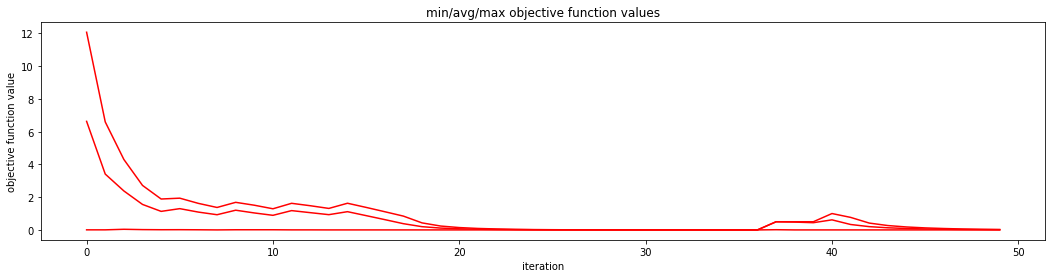

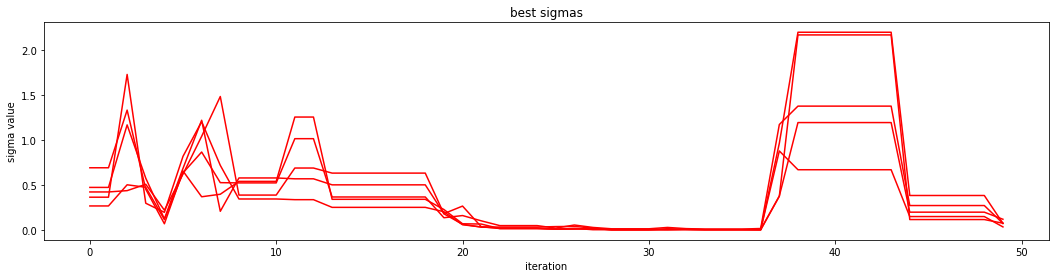

In [6]:
test2.print_plots()

Saving animation...Done


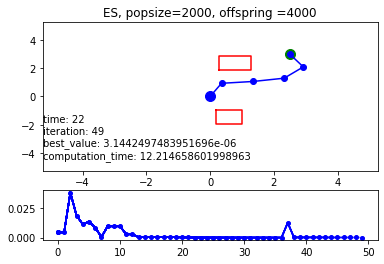

In [7]:
test2.save_animation(filename="double_moving_obstacles")

Saving animation...Done


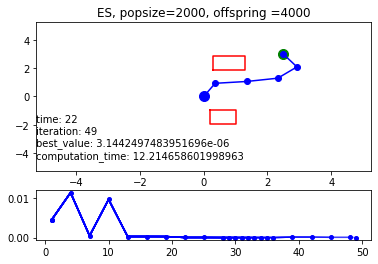

In [8]:
test2.save_animation(filename="double_moving_obstacles-time_frames", best_for_time=True)

# Test 3 - keyhole
keyhole.mp4

Algorytm radzi sobie z trudniejszą przeszkodą, być może jeśli przeszkoda byłaby trudniejsza potrzeba by było więcej czasu na znalezienie początkowego rozwiązania

In [9]:
test3 = keyhole_obstacle_problem()


In [10]:
test3.test()

Iteration 0000 : best score = 0.52277682, mean score = 8.43909123.
Iteration 0020 : best score = 0.07760033, mean score = 0.93369023.
Iteration 0040 : best score = 0.07152341, mean score = 0.63999531.
Iteration 0060 : best score = 0.00000510, mean score = 0.00511184.
Iteration 0080 : best score = 0.00010420, mean score = 0.02124402.
Iteration 0100 : best score = 0.00010600, mean score = 0.38774362.
Iteration 0120 : best score = 0.00000181, mean score = 0.00357588.
Iteration 0140 : best score = 0.00000002, mean score = 0.00004020.
Iteration 0160 : best score = 0.00006410, mean score = 0.05638635.
Iteration 0180 : best score = 0.00001826, mean score = 0.15863250.


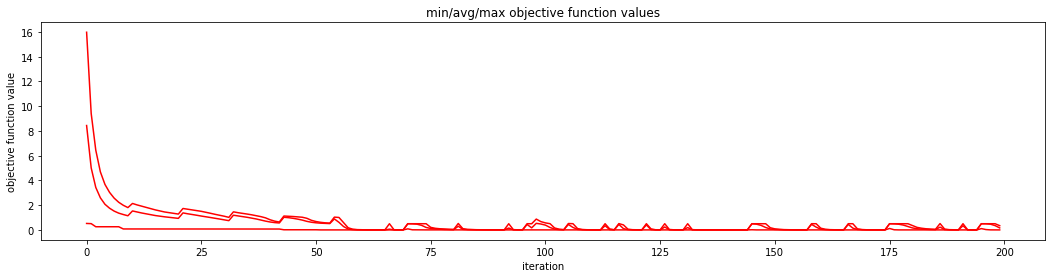

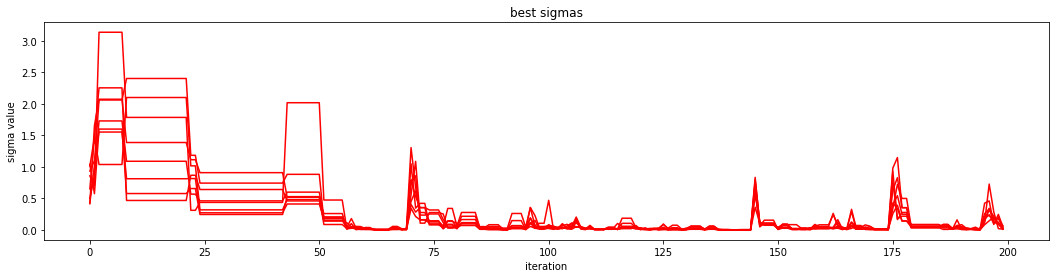

In [11]:
test3.print_plots()

Saving animation...Done


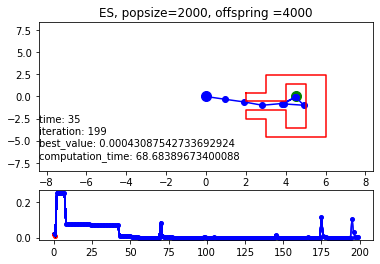

In [12]:
test3.save_animation(filename="keyhole")


Saving animation...Done


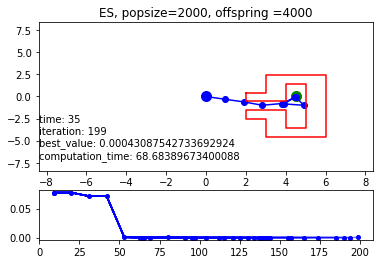

In [13]:
test3.save_animation(filename="keyhole-time_frames", best_for_time=True)

# Test 4, 5 - random problem, 5 obstacles

Algorytm radzi sobie z większą ilością przeszkód. Możemy zauważyć wzrost wartości funkcji celu po napotkaniu przeszkody, ale po chwili wartość funkcji celu znowu spada

In [14]:
def test_random(n, n_obstacles = 11):
    print(f"Test {n}")
    test = multi_obstacle_random_target(n_obstacles= n_obstacles)
    test.test()
    test.print_plots()
    test.save_animation(filename=f"multi{n}")
    test.save_animation(filename=f"multi{n}-timeframes", best_for_time=True)
    return test

Test 4
Iteration 0000 : best score = 0.10045164, mean score = 13.77525601.
Iteration 0020 : best score = 0.00017223, mean score = 0.26374477.
Iteration 0040 : best score = 0.00000001, mean score = 0.00000736.
Iteration 0060 : best score = 0.01966369, mean score = 1.26018974.
Iteration 0080 : best score = 0.00014275, mean score = 0.91607105.
Iteration 0100 : best score = 0.00234815, mean score = 0.50387836.
Iteration 0120 : best score = 0.00005370, mean score = 0.06999493.
Iteration 0140 : best score = 0.00000000, mean score = 0.00000127.
Iteration 0160 : best score = 0.00001321, mean score = 0.31251129.
Iteration 0180 : best score = 0.00259203, mean score = 1.48918117.


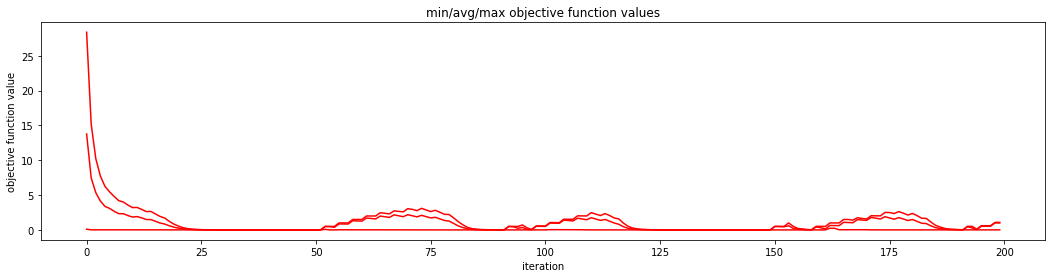

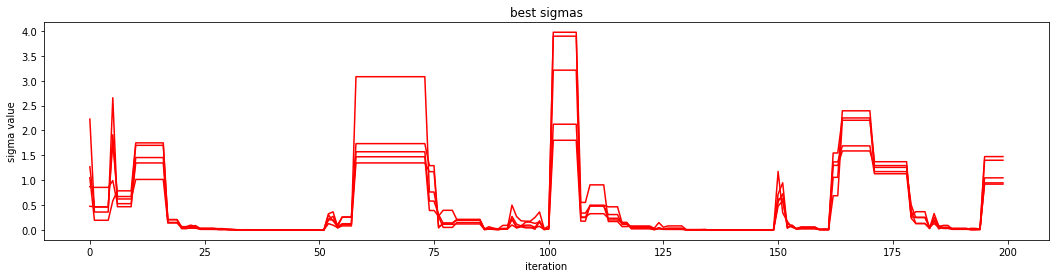

Saving animation...Done
Saving animation...Done


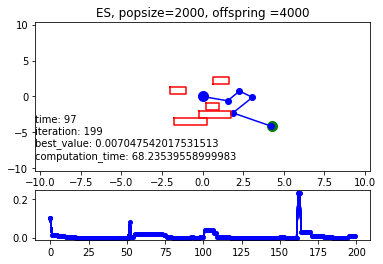

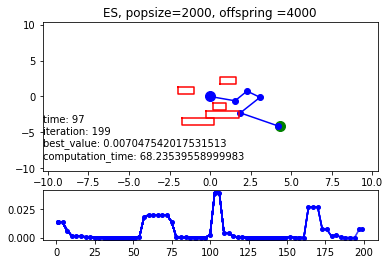

In [15]:
test4 = test_random(4, n_obstacles=5)

Test 5
Iteration 0000 : best score = 0.00579895, mean score = 54.61021991.
Iteration 0020 : best score = 0.00002119, mean score = 0.01286011.
Iteration 0040 : best score = 0.00000009, mean score = 0.00005153.
Iteration 0060 : best score = 0.00001381, mean score = 0.00204501.
Iteration 0080 : best score = 0.00000000, mean score = 0.00000090.
Iteration 0100 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0120 : best score = 0.00000586, mean score = 0.00112319.
Iteration 0140 : best score = 0.00000000, mean score = 0.00000146.
Iteration 0160 : best score = 0.00116688, mean score = 0.43024100.
Iteration 0180 : best score = 0.00000157, mean score = 0.00670100.


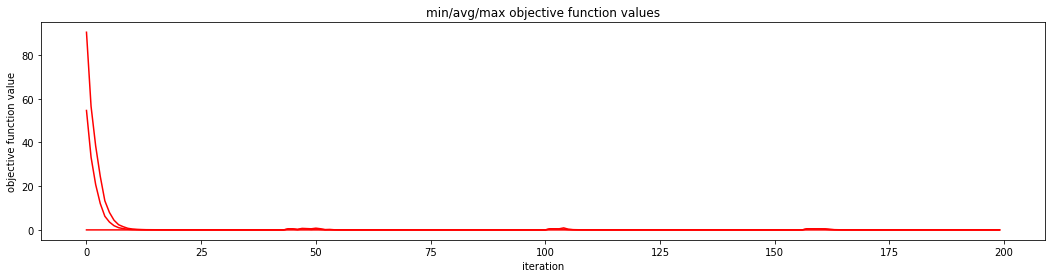

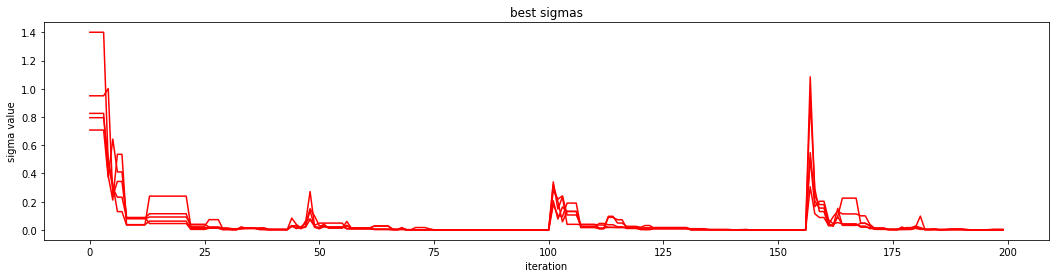

Saving animation...Done
Saving animation...Done


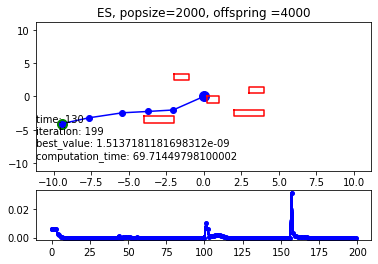

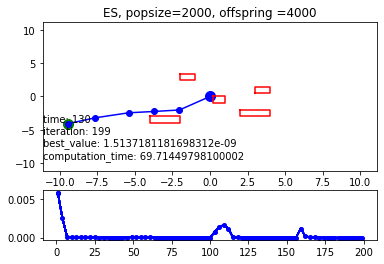

In [16]:
test5 = test_random(5, n_obstacles=5)

Saving animation...Done
Saving animation...Done


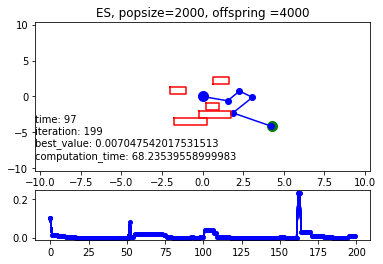

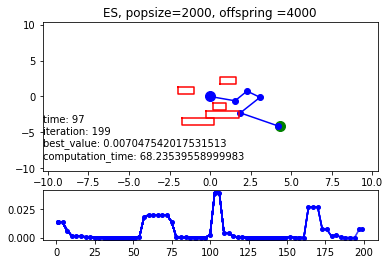

In [17]:
test4.algoritm.iteration_per_time = 10
test4.algoritm.epsilon = 0.001
test4.test()
test4.save_animation('mutli4longtime')
test4.save_animation('mutli4longtime-timeframes', best_for_time=True)


# Tests 6 - 8 - random problem 8 obstacles

Gdy nagle pojawia się dużo przeszkód algorytm potrzebuje więcej czasu na znalezienie rozwiązania  - test6, ale w podobnym przypadku (test7), gdy ramie robota jest nieco inne algortm radzi sobie całkiem dobrze. Jeśli zwiększylibyśmy wartość Algoritm.penalty to powinniśmy znajdować niekolidujące rozwiązania kosztem większych wartości funkcji celu.  
test8 - prosty przypadek

Test 6
Iteration 0000 : best score = 0.16718814, mean score = 34.43101352.
Iteration 0020 : best score = 0.00005079, mean score = 0.10993440.
Iteration 0040 : best score = 0.00000032, mean score = 0.00118813.
Iteration 0060 : best score = 0.50062962, mean score = 1.24050776.
Iteration 0080 : best score = 0.00004569, mean score = 0.05390256.
Iteration 0100 : best score = 0.00863856, mean score = 1.23360375.
Iteration 0120 : best score = 0.00000363, mean score = 0.00245291.
Iteration 0140 : best score = 0.00000000, mean score = 0.00000006.
Iteration 0160 : best score = 0.50038529, mean score = 1.26503479.
Iteration 0180 : best score = 0.00101062, mean score = 1.67323769.


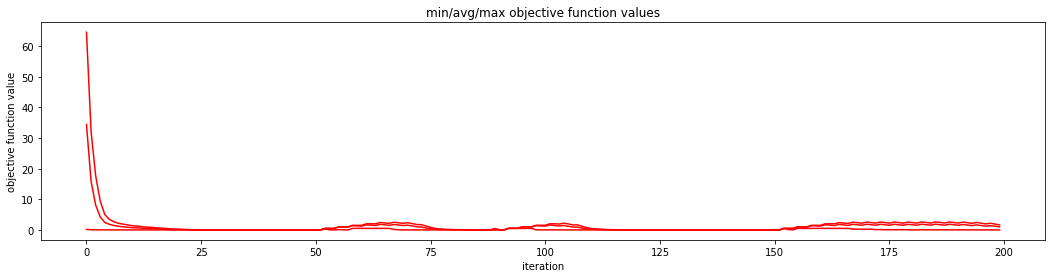

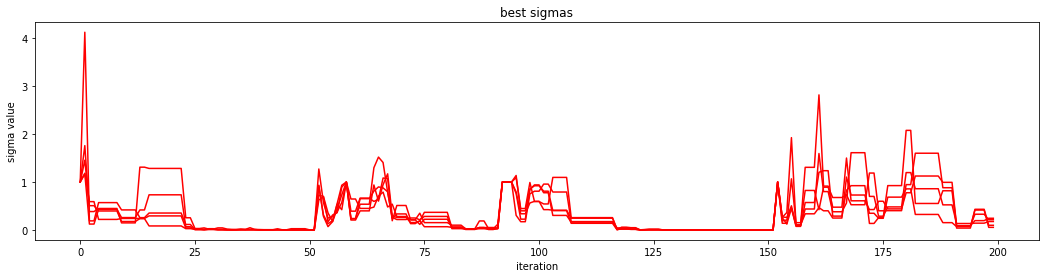

Saving animation...Done
Saving animation...Done


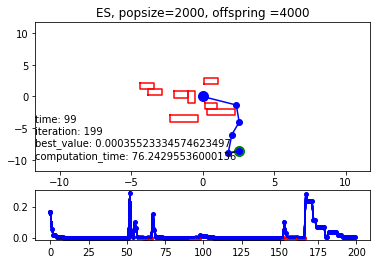

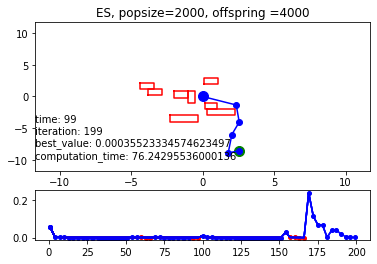

In [18]:
test_random(6, n_obstacles=8)

Test 7
Iteration 0000 : best score = 0.06873796, mean score = 13.69669526.
Iteration 0020 : best score = 0.00085884, mean score = 0.52919415.
Iteration 0040 : best score = 0.00000010, mean score = 0.00007511.
Iteration 0060 : best score = 0.26297457, mean score = 1.38009561.
Iteration 0080 : best score = 0.00103617, mean score = 0.63989691.
Iteration 0100 : best score = 0.00753699, mean score = 0.94589867.
Iteration 0120 : best score = 0.00504290, mean score = 0.70595226.
Iteration 0140 : best score = 0.00000002, mean score = 0.00005574.
Iteration 0160 : best score = 0.00193990, mean score = 0.65401351.
Iteration 0180 : best score = 0.00133784, mean score = 1.27560320.


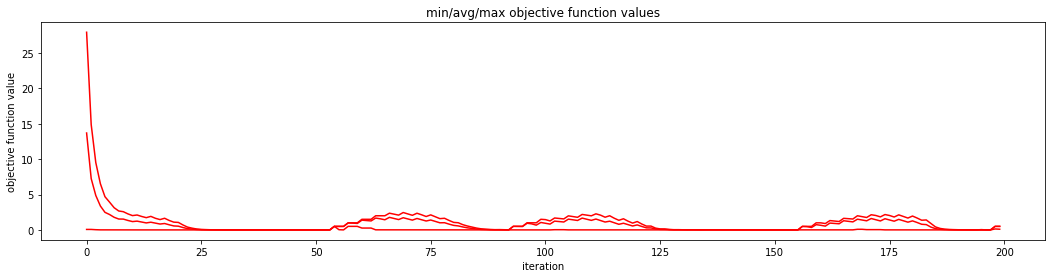

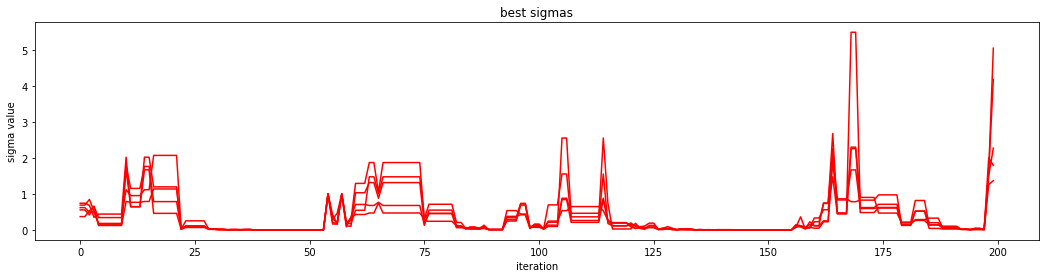

Saving animation...Done
Saving animation...Done


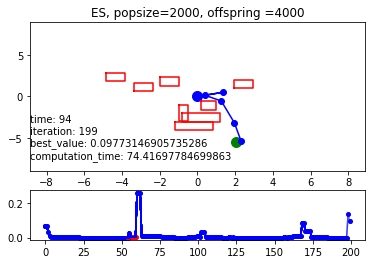

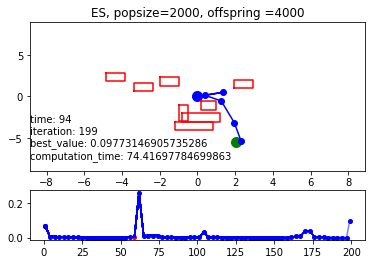

In [19]:
test_random(7, n_obstacles=8)

Test 8
Iteration 0000 : best score = 0.02830706, mean score = 13.56733600.
Iteration 0020 : best score = 0.00000087, mean score = 0.00238300.
Iteration 0040 : best score = 0.00000001, mean score = 0.00000871.
Iteration 0060 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0080 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0100 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0120 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0140 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0160 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0180 : best score = 0.00000000, mean score = 0.00000000.


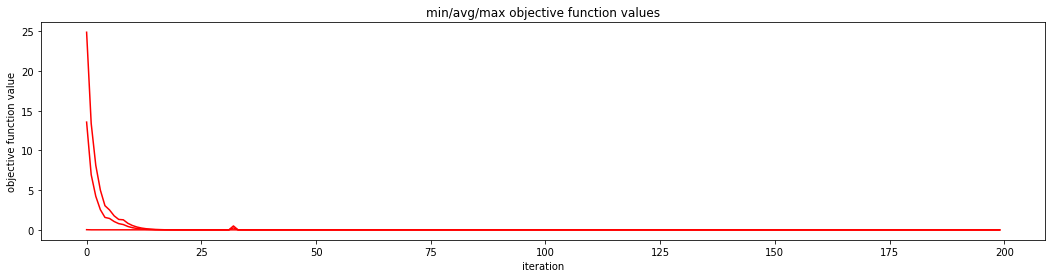

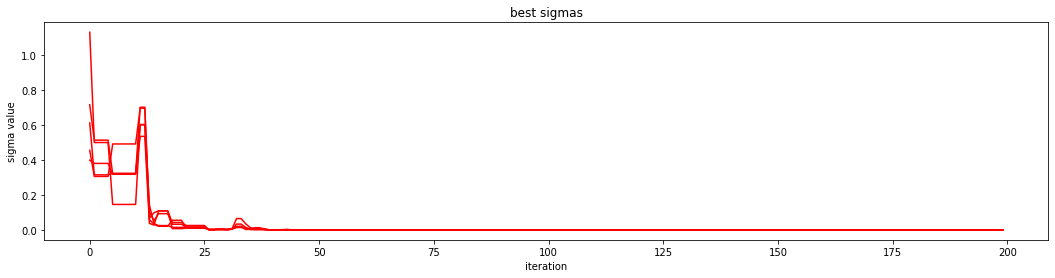

Saving animation...Done
Saving animation...Done


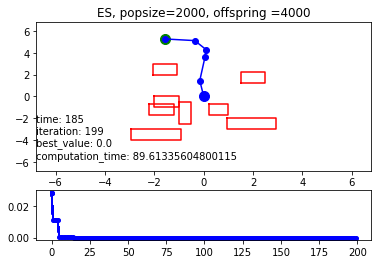

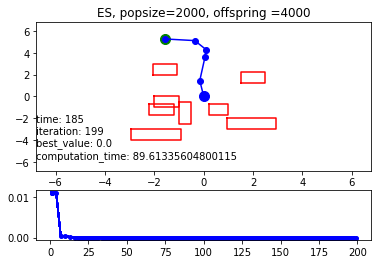

In [20]:
test_random(8, n_obstacles=8)

# Tests 9 - 15 - random problem 11 obstacles

- test 9 - mimo dużej ilości wymijanych przeszkód nie znaleźliśmy niekolidującego rozwiązania tylko dla jednego czasu, duża ilość skoków ramienia sprawiła, że wartość celu po tych przeskokach znacząco wzrosła  
- test 11 - widzimy że po kilku kolidujących, ale dość bliskich celu rozwiązaniach znaleźliśmy nieco dalsze ale poprawne rozwiązanie, dla większej wartości Algoritm.penalty pewnie szybciej zdecydowalibyśmy się na niekolidujące, ale gorsze rozwiązanie  
- test 12, 14 - udało się uzyskać dość dużą dokładność przez cały czas trwania animacji  
- test 13 - przypadek nie do rozwiązania - cel wylosowany nieco poza zasięgiem ramienia  
- test 15 - jak w 13, tutaj radzimy sobie trochę lepiej z wymijaniem przeszkód, bo są prostrze   

Test 9
Iteration 0000 : best score = 0.06562151, mean score = 7.82639854.
Iteration 0020 : best score = 0.00016454, mean score = 0.53641362.
Iteration 0040 : best score = 0.00000003, mean score = 0.00006101.
Iteration 0060 : best score = 0.00160173, mean score = 1.52454491.
Iteration 0080 : best score = 0.50102446, mean score = 0.99982350.
Iteration 0100 : best score = 0.00729663, mean score = 1.16239407.
Iteration 0120 : best score = 0.00000614, mean score = 0.04044910.
Iteration 0140 : best score = 0.07397257, mean score = 1.29525191.
Iteration 0160 : best score = 0.02359700, mean score = 0.94266419.
Iteration 0180 : best score = 0.00006068, mean score = 0.02684437.


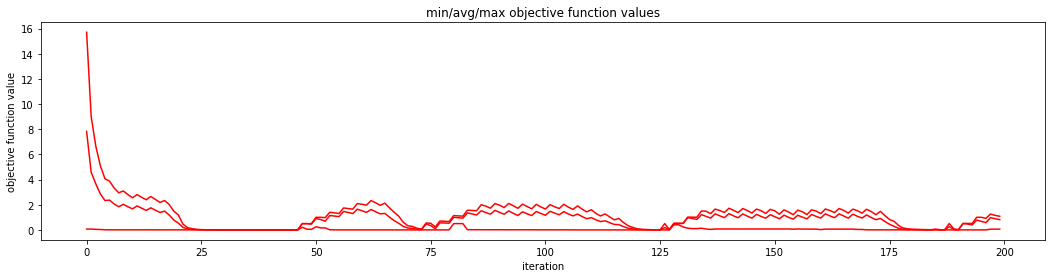

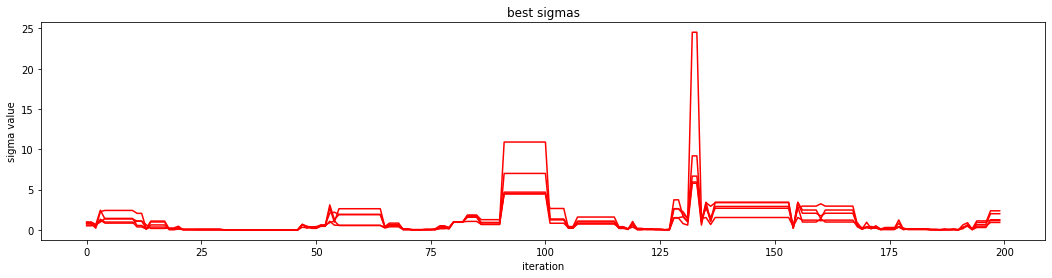

Saving animation...Done
Saving animation...Done


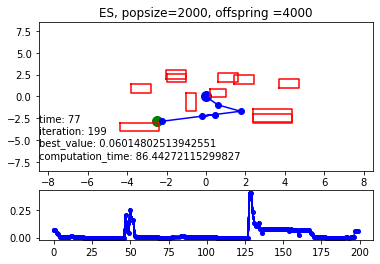

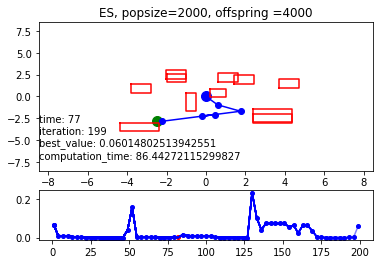

In [21]:
test_random(9)

Test 10
Iteration 0000 : best score = 0.37674179, mean score = 10.38855852.
Iteration 0020 : best score = 0.00102576, mean score = 1.63380090.
Iteration 0040 : best score = 0.00029938, mean score = 0.39631448.
Iteration 0060 : best score = 0.02240961, mean score = 0.49873671.
Iteration 0080 : best score = 0.00000146, mean score = 0.00095162.
Iteration 0100 : best score = 0.00002248, mean score = 0.00905587.
Iteration 0120 : best score = 0.00382222, mean score = 0.48381957.
Iteration 0140 : best score = 0.00001945, mean score = 0.01549982.
Iteration 0160 : best score = 0.00000087, mean score = 0.00163746.
Iteration 0180 : best score = 0.00070851, mean score = 0.47499872.


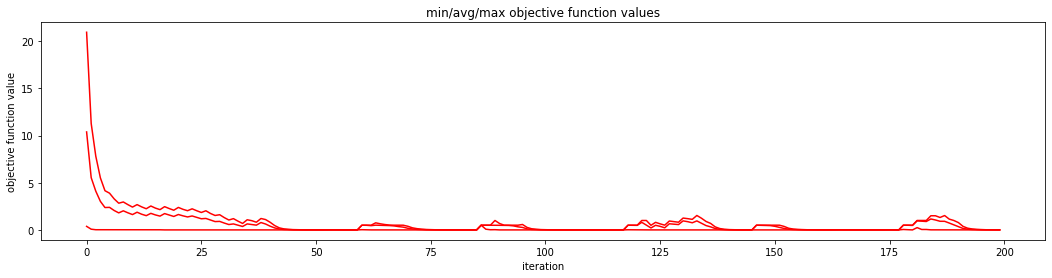

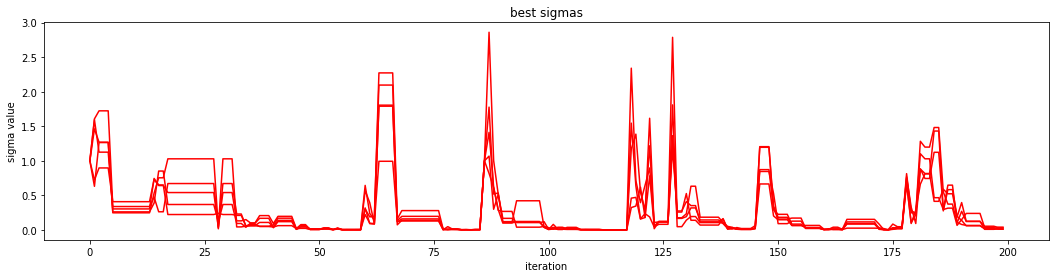

Saving animation...Done
Saving animation...Done


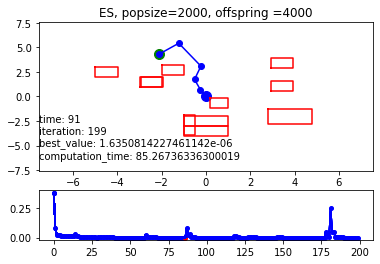

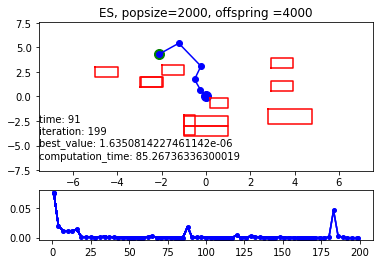

In [22]:
test_random(10)

Test 11
Iteration 0000 : best score = 0.16336233, mean score = 8.19035376.
Iteration 0020 : best score = 0.00001938, mean score = 0.04973092.
Iteration 0040 : best score = 0.00000000, mean score = 0.00000116.
Iteration 0060 : best score = 0.50036256, mean score = 1.11416291.
Iteration 0080 : best score = 0.00118277, mean score = 0.83532905.
Iteration 0100 : best score = 0.00000429, mean score = 0.04955870.
Iteration 0120 : best score = 0.00000000, mean score = 0.00000144.
Iteration 0140 : best score = 0.50000000, mean score = 0.50000000.
Iteration 0160 : best score = 0.01620184, mean score = 0.99143429.
Iteration 0180 : best score = 0.50009094, mean score = 1.18318277.


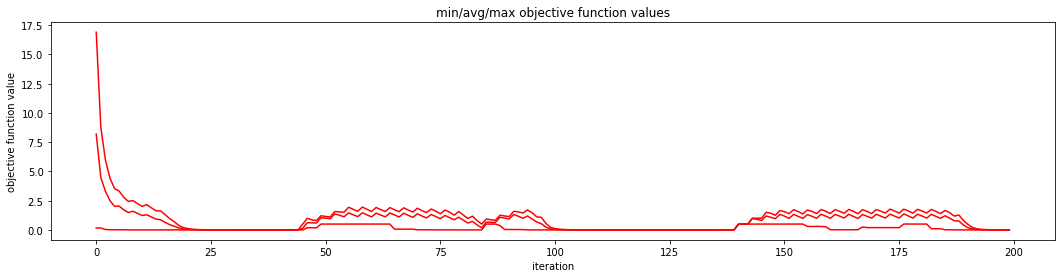

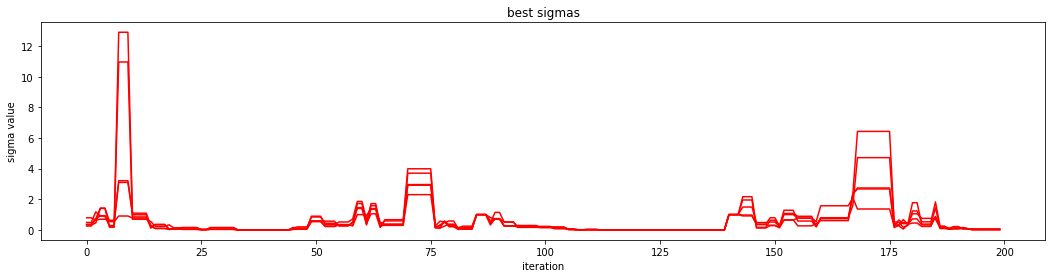

Saving animation...Done
Saving animation...Done


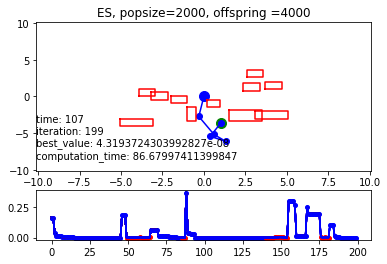

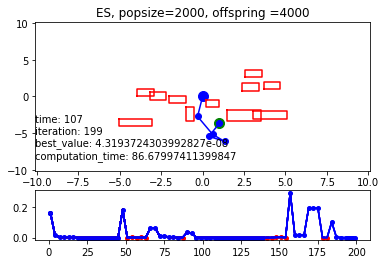

In [23]:
test_random(11)

Test 12
Iteration 0000 : best score = 0.00081861, mean score = 3.44736662.
Iteration 0020 : best score = 0.00068520, mean score = 0.99770135.
Iteration 0040 : best score = 0.00000011, mean score = 0.00299734.
Iteration 0060 : best score = 0.00006349, mean score = 0.15331429.
Iteration 0080 : best score = 0.00000000, mean score = 0.00000058.
Iteration 0100 : best score = 0.00000201, mean score = 0.00123410.
Iteration 0120 : best score = 0.00000000, mean score = 0.00000110.
Iteration 0140 : best score = 0.00000001, mean score = 0.00048301.
Iteration 0160 : best score = 0.00030394, mean score = 0.14802092.
Iteration 0180 : best score = 0.00000349, mean score = 0.00769175.


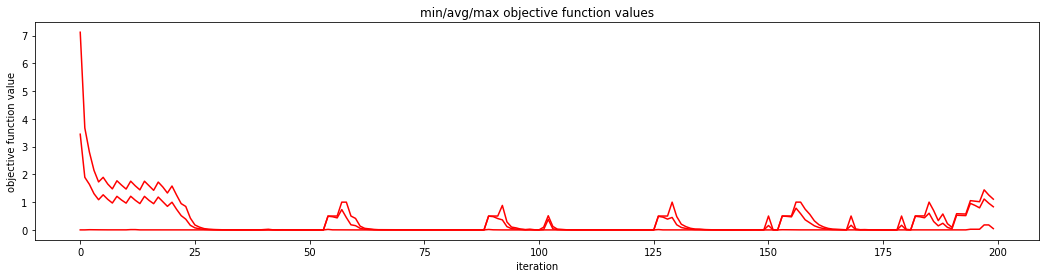

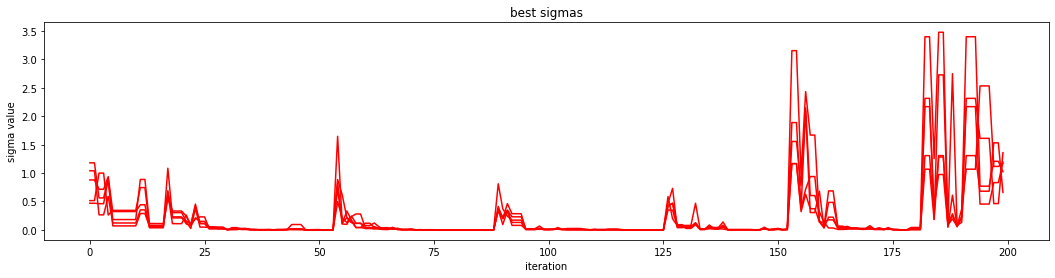

Saving animation...Done
Saving animation...Done


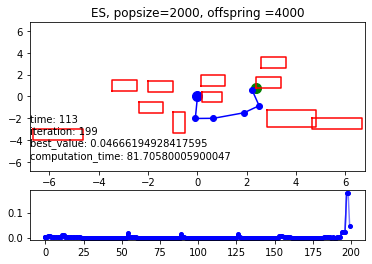

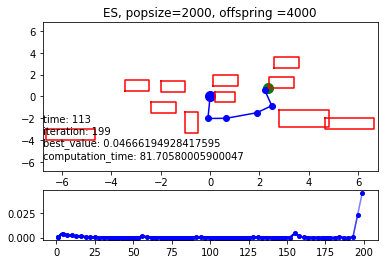

In [24]:
test_random(12)

Test 13
Iteration 0000 : best score = 0.78867279, mean score = 40.21638125.
Iteration 0020 : best score = 0.52396821, mean score = 2.26199683.
Iteration 0040 : best score = 0.52690369, mean score = 1.85531244.
Iteration 0060 : best score = 0.01339203, mean score = 0.03323629.
Iteration 0080 : best score = 0.25303002, mean score = 1.99584860.
Iteration 0100 : best score = 0.52501600, mean score = 1.99192241.
Iteration 0120 : best score = 0.07669544, mean score = 0.63786797.
Iteration 0140 : best score = 0.52666798, mean score = 2.12285819.
Iteration 0160 : best score = 0.51550717, mean score = 1.93683448.
Iteration 0180 : best score = 0.55089319, mean score = 2.03633571.


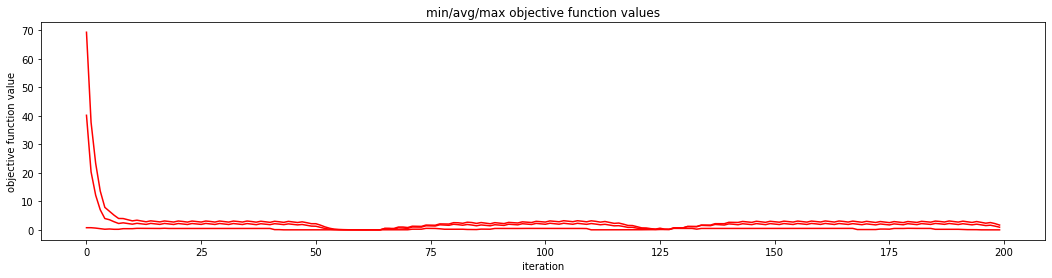

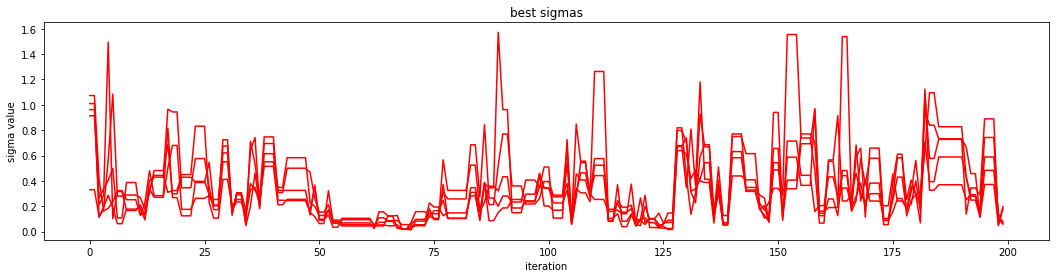

Saving animation...Done
Saving animation...Done


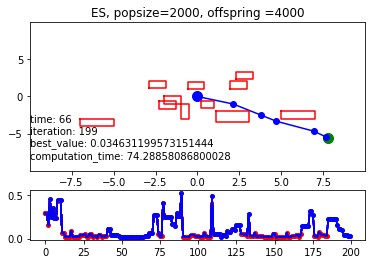

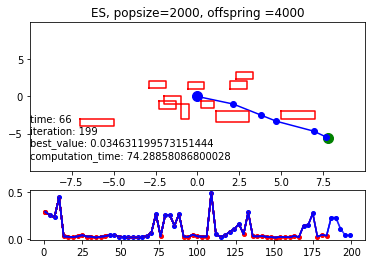

In [25]:
test_random(13)

Test 14
Iteration 0000 : best score = 0.01583522, mean score = 18.18792619.
Iteration 0020 : best score = 0.00722216, mean score = 1.54057703.
Iteration 0040 : best score = 0.00139660, mean score = 0.44827126.
Iteration 0060 : best score = 0.01262417, mean score = 0.49530138.
Iteration 0080 : best score = 0.00137209, mean score = 1.21627536.
Iteration 0100 : best score = 0.00056658, mean score = 0.48166745.
Iteration 0120 : best score = 0.00087698, mean score = 0.51752123.
Iteration 0140 : best score = 0.00001392, mean score = 0.01780499.
Iteration 0160 : best score = 0.00049402, mean score = 0.30966525.
Iteration 0180 : best score = 0.00052817, mean score = 0.61243006.


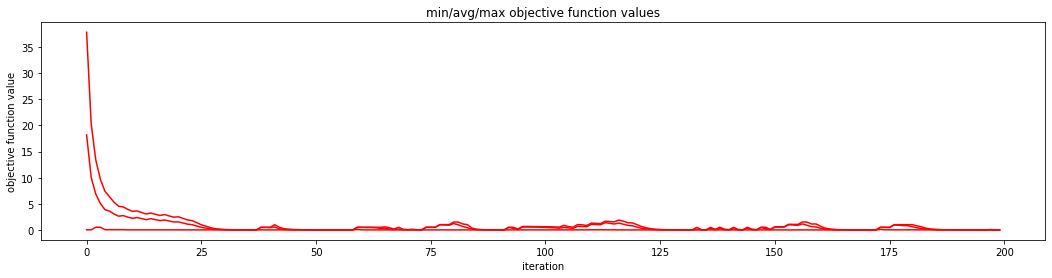

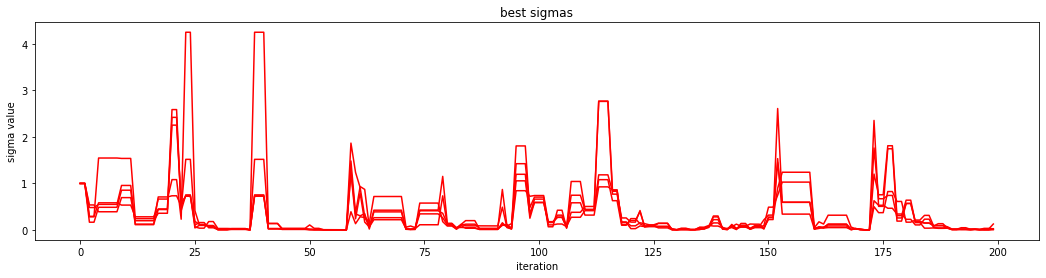

Saving animation...Done
Saving animation...Done


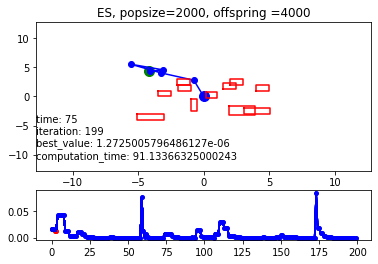

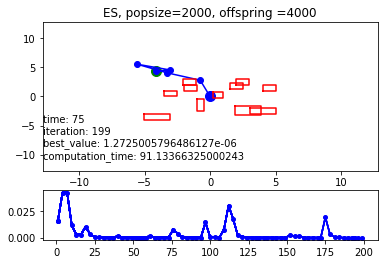

In [26]:
test_random(14)

Test 15
Iteration 0000 : best score = 2.23819445, mean score = 45.55044712.
Iteration 0020 : best score = 0.12698562, mean score = 1.49877703.
Iteration 0040 : best score = 0.34038946, mean score = 1.20899244.
Iteration 0060 : best score = 0.30170551, mean score = 0.68762728.
Iteration 0080 : best score = 0.45595232, mean score = 1.89097624.
Iteration 0100 : best score = 0.17912960, mean score = 0.22029109.
Iteration 0120 : best score = 0.58455721, mean score = 1.18840883.
Iteration 0140 : best score = 0.11216947, mean score = 0.14329167.
Iteration 0160 : best score = 0.29104332, mean score = 0.65232653.
Iteration 0180 : best score = 0.13219808, mean score = 0.23206769.


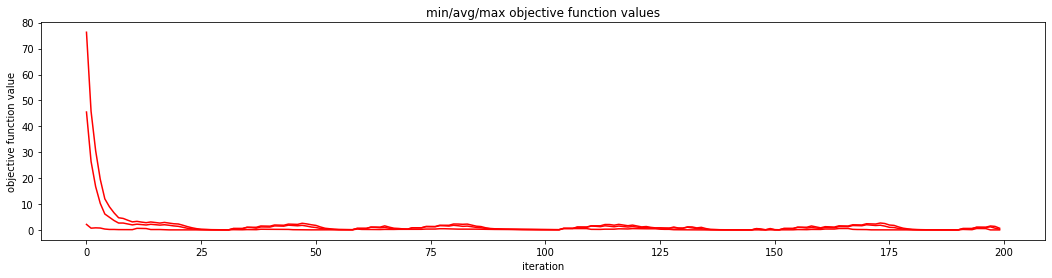

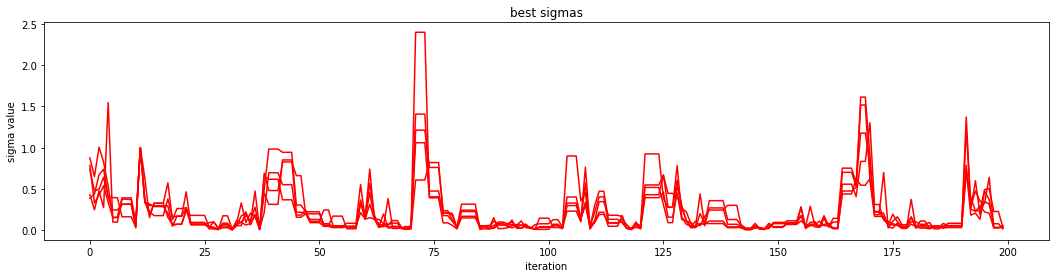

Saving animation...Done
Saving animation...Done


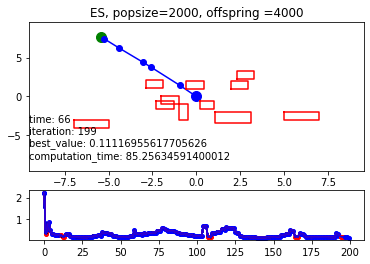

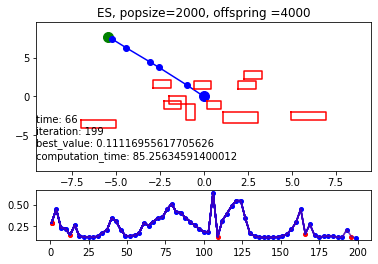

In [27]:
test_random(15)